In [74]:
import os

# set the environment variable to control the number of threads
# NEEDS TO BE DONE BEFORE CCL IS IMPORTED
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import emcee
import h5py as h5
from scipy.stats import qmc

from copy import deepcopy

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from parallelbar import progress_starmap

from time import time

from importlib import reload
reload(training)
reload(models)

<module 'src.models' from '/home/b7009348/CosyMAML/src/models.py'>

In [75]:
def compute_spectra(cosmo, dndz_ph_bins, z_ph, ells, ia_model):
    
        n_bins = len(dndz_ph_bins)
        indices = np.tril_indices(n_bins)
        zipped_inds = list(zip(*indices))
    
        c_ells = np.empty((len(zipped_inds), len(ells)))
        for i, arg in enumerate(zipped_inds):
            j, k = arg
            tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph[j], dndz_ph_bins[j]), ia_bias=ia_model, use_A_ia=False)
            tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph[k], dndz_ph_bins[k]), ia_bias=ia_model, use_A_ia=False)
            c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)

        return c_ells

300
[0.11070451 0.6780883  1.        ]


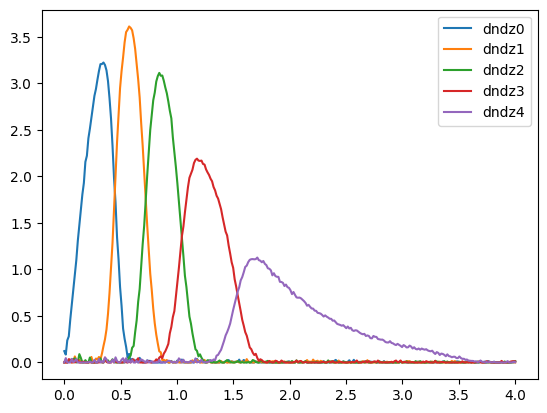

In [76]:
# Load a distribution from original training sample
filepath = 'data/1000tasks_5000samples_44seed.h5'
f = h5.File(filepath, 'r')

dist = 57
dndz_ph = f['dndz'][dist]
z_ph = f['z'][dist]
print(len(z_ph[0]))
print(f['dndz_params'][dist])

#plot
for i in range(dndz_ph.shape[0]):
    plt.plot(z_ph[i], dndz_ph[i], label='dndz{}'.format(i))
plt.legend()

## Test training across different IA models

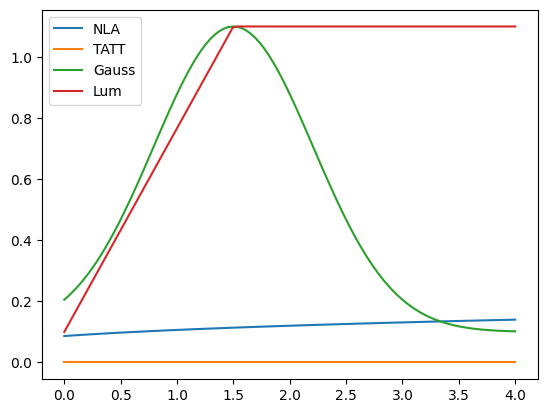

In [77]:
# Define 4 different IA models with the same number of input parameters
# 1. NLA model
def nla_model(z, z0, a_IA, eta):
    return a_IA * ((1+z)/(1+z0))**eta

def tattish_model(z, z0, a_1, a_2, eta_1, eta_2):
    return a_1 * ((1+ z)/(1+z0))**eta_1 - a_2 * ((1+ z)/(1+z0))**eta_2

def gauss_model(z, a_IA, z_b, sigma_z):
    return a_IA + np.exp(-((z - z_b)/1.0)**2)

def trunc_model(z, a_IA, z_trunc):
    return a_IA + np.minimum(1.0, z / z_trunc)

# Plot the models
z = np.linspace(0, 4, 100)
z0 = 0.62
a_IA = 0.1
eta = 0.3
a_1 = 0.1
a_2 = 0.1
eta_1 = 0.3
eta_2 = 0.3
z_b = 1.5
sig_z = 1.2
z_trunc = 1.5

plt.plot(z, nla_model(z, z0, a_IA, eta), label='NLA')
plt.plot(z, tattish_model(z, z0, a_1, a_2, eta_1, eta_2), label='TATT')
plt.plot(z, gauss_model(z, a_IA, z_b, sig_z), label='Gauss')
plt.plot(z, trunc_model(z, a_IA, z_trunc), label='Lum')
plt.legend()

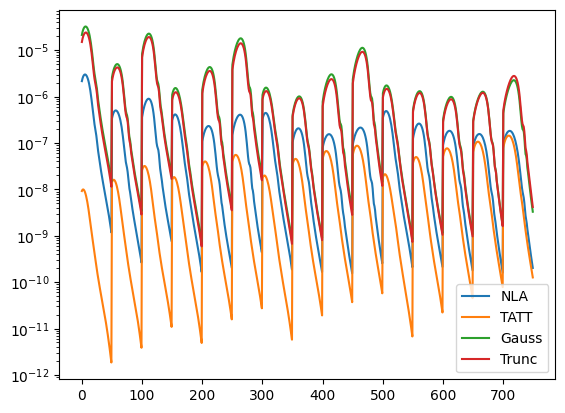

In [78]:
# define cosmology
cosmo = ccl.Cosmology(Omega_c=0.07, Omega_b=0.03, h=0.55, sigma8=0.87, n_s=1.07)

ells = np.geomspace(2, 2000, 50)

# Open a pool to simultaneously compute the spectra for each model
n_proc = 4
pool = Pool(n_proc)

ia_nla = (z_ph[0], nla_model(z_ph[0], z0, a_IA, eta))
ia_tatt = (z_ph[0], tattish_model(z_ph[0], z0, a_1, a_2, eta_1, eta_2))
ia_gauss = (z_ph[0], gauss_model(z_ph[0], a_IA, z_b, sig_z))
ia_trunc = (z_ph[0], trunc_model(z_ph[0], a_IA, z_trunc))

args = [(cosmo, dndz_ph, z_ph, ells, ia_nla),
        (cosmo, dndz_ph, z_ph, ells, ia_tatt),
        (cosmo, dndz_ph, z_ph, ells, ia_gauss),
        (cosmo, dndz_ph, z_ph, ells, ia_trunc)]

c_ells = pool.starmap(compute_spectra, args)
c_ells = [c_ell.flatten() for c_ell in c_ells]

plt.plot(c_ells[0], label='NLA')
plt.plot(c_ells[1], label='TATT')
plt.plot(c_ells[2], label='Gauss')
plt.plot(c_ells[3], label='Trunc')
plt.yscale('log')
plt.legend()

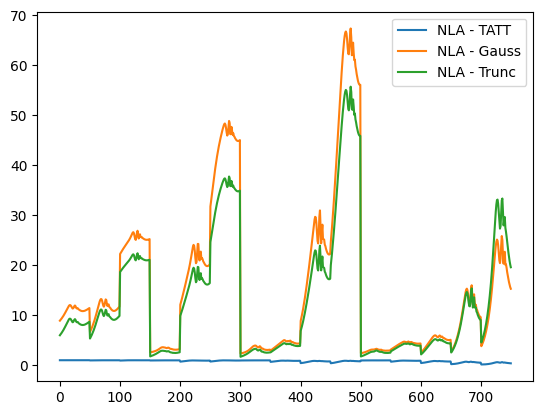

In [79]:
# Plot absolute percent difference between models
plt.plot(np.abs(c_ells[0] - c_ells[1])/c_ells[0], label='NLA - TATT')
plt.plot(np.abs(c_ells[0] - c_ells[2])/c_ells[0], label='NLA - Gauss')
plt.plot(np.abs(c_ells[0] - c_ells[3])/c_ells[0], label='NLA - Trunc')
plt.legend()

In [80]:
def compute_cosmo_spectra(theta, ia_model, dndz_ph_bins, z_ph, ells):
    
    cosmo = ccl.Cosmology(
         Omega_c=theta[0],
         Omega_b=theta[1],
         h=theta[2],
         n_s=theta[3],
         sigma8=theta[4]
        )
    
    return compute_spectra(cosmo, dndz_ph_bins, z_ph, ells, ia_model)

In [81]:
# Define cosmology parameter ranges
Omega_m = np.array([0.05, 0.95])
Omega_b = np.array([0.025, 0.075])
Omega_c = Omega_m - Omega_b

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

# Define reasonably small IA parameter ranges
ia_param_ranges = [
    [np.array((0.2, 0.6)), np.array((0.1, 1.0)), np.array((0, 0.3))], # NLA
    [np.array((0.2, 0.6)), np.array((0.5, 1.0)), np.array((0.1, 0.2)), np.array((0, 0.3)), np.array((1, 1.5))], # TATT
    [np.array((0.1, 0.5)), np.array((0.5, 1.5)), np.array((0.6, 1.2))], # Gauss
    [np.array((0.1, 1.0)), np.array((1.5, 2.5))] # Trunc
]

ia_model_names = ['NLA', 'TATT', 'Gauss', 'Trunc']
ia_models = [nla_model, tattish_model, gauss_model, trunc_model]

# Determine the maximum number of IA parameters
max_ia_params = max(len(params) for params in ia_param_ranges)

# Combine cosmology and IA parameter ranges for each model
cosmo_ranges = [Omega_c, Omega_b, h, n_s, sigma8]
param_ranges = [
    cosmo_ranges + ia_params
    for ia_params in ia_param_ranges
]
print(param_ranges[0])

[array([0.025, 0.875]), array([0.025, 0.075]), array([0.55, 0.91]), array([0.87, 1.07]), array([0.6, 0.9]), array([0.2, 0.6]), array([0.1, 1. ]), array([0. , 0.3])]


In [82]:
# Generate the training dataset
n_tasks = len(param_ranges)
n_samples = 5000
filename = 'data/IA_models_{}samples.h5'.format(n_samples)

if os.path.exists(filename):
    pass
else:
    # Multiprocessing
    n_proc = cpu_count()
    c_ell_task = []
    with h5.File(filename, 'w') as ia_file:
        # Save redshift distribution placeholders (already defined)
        ia_file.create_dataset('dndz', data=dndz_ph)
        ia_file.create_dataset('z', data=z_ph)
        
        for i, ranges in enumerate(param_ranges):
            # Number of dimensions for this task
            active_dims = len(ranges)
            ranges = np.array(ranges)
            l_bounds = ranges.T[0]
            u_bounds = ranges.T[1]
            
            # Create Latin Hypercube
            sampler = qmc.LatinHypercube(d=active_dims)
            hypercube = sampler.random(n_samples)
            
            # Scale hypercube to parameter ranges
            scaled_samples = qmc.scale(hypercube, l_bounds, u_bounds)

            # compute A_IA for each sample
            ia_params = scaled_samples[:, 5:]
            ia_model = [(z_ph[0], ia_models[i](z_ph[0], *params)) for params in ia_params]

            # Pad samples to match maximum dimensionality
            n_pad = max_ia_params + len(cosmo_ranges) - active_dims
            padded_samples = np.hstack((scaled_samples, np.zeros((n_samples, n_pad))))
            
            # Save the scaled samples for this task
            ia_file.create_dataset(ia_model_names[i], data=scaled_samples)

            # Generate the C_ell values for each sample 
            arglist = [(scaled_samples[j, :5], ia_model[j], dndz_ph, z_ph, ells)
                        for j in range(n_samples)]
                
            c_ells = list(progress_starmap(compute_cosmo_spectra, arglist, n_cpu=n_proc))

            # Flatten the C_ell values
            c_ells = np.array(c_ells)
            c_ells = c_ells.reshape(n_samples, -1)

            # Save the C_ell values for this task
            ia_file.create_dataset(ia_model_names[i]+'_c_ells', data=c_ells)
            c_ell_task.append(c_ells)

            print('Task {} completed'.format(i))

In [83]:
# create torch dataloader from h5 file
ia_file = h5.File(filename, 'r')
nla_samples = ia_file['NLA'][:]
nla_c_ells = ia_file['NLA_c_ells'][:]
# delete the zeros from the padded samples
nla_samples = nla_samples[:, :8]
print(nla_samples.shape)
X = nla_samples
y = np.log(nla_c_ells)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to('cuda')
X_test = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.float32).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.float32).to('cuda')

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

print("Checking inputs and targets for NaN or Inf...")
print(f"X_train contains NaN: {torch.isnan(X_train).any()}")
print(f"y_train contains NaN: {torch.isnan(y_train).any()}")
print(f"X_test contains Inf: {torch.isinf(X_test).any()}")
print(f"y_test contains Inf: {torch.isinf(y_test).any()}")

# Create the dataloaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

(5000, 8)
Checking inputs and targets for NaN or Inf...
X_train contains NaN: False
y_train contains NaN: False
X_test contains Inf: False
y_test contains Inf: False


8
Epoch 0 Loss: 1.026784062385559
Epoch 10 Loss: 0.2806674540042877
Epoch 20 Loss: 0.14945143461227417
Epoch 30 Loss: 0.12159080058336258
Epoch 40 Loss: 0.09726917743682861
Epoch 50 Loss: 0.0812823697924614
Epoch 60 Loss: 0.06855940073728561
Epoch 70 Loss: 0.056858886033296585
Epoch 80 Loss: 0.04625030606985092
Epoch 90 Loss: 0.038181837648153305
Epoch 100 Loss: 0.0321054607629776
Epoch 110 Loss: 0.02843441814184189
Epoch 120 Loss: 0.026368161663413048
Epoch 130 Loss: 0.02316145971417427
Epoch 140 Loss: 0.021297812461853027
Epoch 150 Loss: 0.019944464787840843
Epoch 160 Loss: 0.017556002363562584
Epoch 170 Loss: 0.01603851094841957
Epoch 180 Loss: 0.015176010318100452
Epoch 190 Loss: 0.01361220795661211
Epoch 200 Loss: 0.013785420916974545
Epoch 210 Loss: 0.012897470965981483
Epoch 220 Loss: 0.012361938133835793
Epoch 230 Loss: 0.011586961336433887
Epoch 240 Loss: 0.01147349365055561
Epoch 250 Loss: 0.01120145432651043
Epoch 260 Loss: 0.011796077713370323
Epoch 270 Loss: 0.010307369753

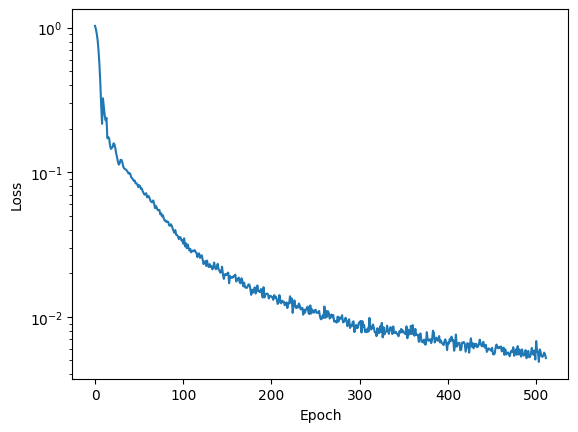

In [84]:
# Define the model
in_size = 10
print(X_train.shape[1])
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)
model.to('cuda')

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the loss function
loss_fn = torch.nn.MSELoss()

n_epochs = 512

train_losses = []
for epoch in range(n_epochs):
    X_batch, y_batch = next(iter(train_loader))

    if X_batch.shape[1] < in_size:
        # pad with zeros
        X_batch = torch.cat([X_batch, torch.zeros(X_batch.shape[0], in_size - X_batch.shape[1]).to('cuda')], dim=1)

    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

    train_losses.append(loss.item())

original_model = deepcopy(model.state_dict())

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

Total predictions: torch.Size([1000, 750])


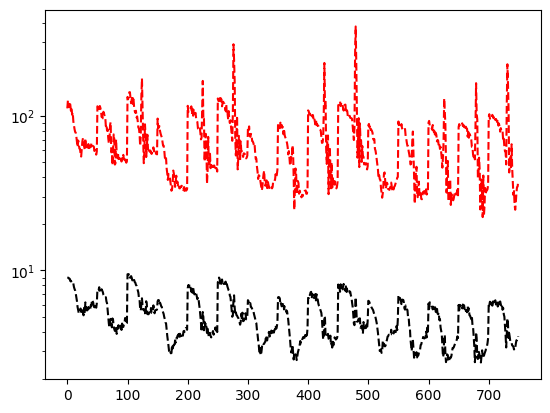

In [85]:
# Construct empty tensor to store predictions
model.eval()
y_pred = torch.tensor([]).to('cuda')
test_losses = []
for X_batch, y_batch in test_loader:
    if X_batch.shape[1] < in_size:
        # pad with zeros
        X_batch = torch.cat([X_batch, torch.zeros(X_batch.shape[0], in_size - X_batch.shape[1]).to('cuda')], dim=1)
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = model(X_batch)
        test_losses.append(loss_fn(y_pred_batch, y_batch).item())
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)

y_pred = torch.exp(ScalerY.inverse_transform(y_pred)).cpu().detach().numpy()
#y_pred = torch.exp(y_pred).cpu().detach().numpy()
y_true = torch.exp(y_test).cpu().detach().numpy()

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100
worst_ape = np.max(np.abs((y_true - y_pred) / y_true), axis=0) * 100
best_ape = np.min(np.abs((y_true - y_pred) / y_true), axis=0) * 100
plt.plot(mape, c='k', ls='--')
plt.plot(worst_ape, c='r', ls='--')
plt.yscale('log')

### Attempt MAML training over different IA models

In [88]:
nla_inputs = ia_file['NLA'][:]
nla_c_ells = ia_file['NLA_c_ells'][:]
tatt_inputs = ia_file['TATT'][:]
tatt_c_ells = ia_file['TATT_c_ells'][:]
gauss_inputs = ia_file['Gauss'][:]
gauss_c_ells = ia_file['Gauss_c_ells'][:]
trunc_inputs = ia_file['Trunc'][:]
trunc_c_ells = ia_file['Trunc_c_ells'][:]

# Append into training data of shape (n_tasks, n_samples, n_features)
X_train = np.array([nla_inputs, tatt_inputs, gauss_inputs])
y_train = np.array([nla_c_ells, tatt_c_ells, gauss_c_ells])

y_log = np.log(y_train)

print(X_train.shape, y_train.shape)

# Make torch tensors and send to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_log, dtype=torch.float32).to('cuda')

print("Checking inputs and targets for NaN or Inf...")
print(f"X_train contains NaN: {torch.isnan(X_train).any()}")
print(f"y_train contains NaN: {torch.isnan(y_train).any()}")

batch_size=3

# create torch dataloader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

(3, 5000, 10) (3, 5000, 750)
Checking inputs and targets for NaN or Inf...
X_train contains NaN: False
y_train contains NaN: False


In [89]:
meta_model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Initialise a MetaLearner
metalearner = training.MetaLearner(
    model=meta_model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device='cuda'
)

Epoch 1/100 - Meta Loss: 0.0024181483313441277
Epoch 2/100 - Meta Loss: 0.0005708912503905594
Epoch 3/100 - Meta Loss: 3.78950426238589e-05
Epoch 4/100 - Meta Loss: 5.125062216393417e-06
Epoch 5/100 - Meta Loss: 3.7837842228327645e-06
Epoch 6/100 - Meta Loss: 2.612820935610216e-06
Epoch 7/100 - Meta Loss: 2.253484126413241e-06
Epoch 8/100 - Meta Loss: 2.050234343187185e-06
Epoch 9/100 - Meta Loss: 1.561590465826157e-06
Epoch 10/100 - Meta Loss: 2.1327177819330245e-06
Epoch 11/100 - Meta Loss: 1.4577811953131459e-06
Epoch 12/100 - Meta Loss: 9.75053467300313e-07
Epoch 13/100 - Meta Loss: 9.498486974734988e-07
Epoch 14/100 - Meta Loss: 7.001851827226346e-07
Epoch 15/100 - Meta Loss: 6.135090870884596e-07
Epoch 16/100 - Meta Loss: 5.479820401887991e-07
Epoch 17/100 - Meta Loss: 4.971841462975135e-07
Epoch 18/100 - Meta Loss: 4.577944991979166e-07
Epoch 19/100 - Meta Loss: 4.121486369967897e-07
Epoch 20/100 - Meta Loss: 3.754507247322181e-07
Epoch 21/100 - Meta Loss: 3.4229367429361446e-07

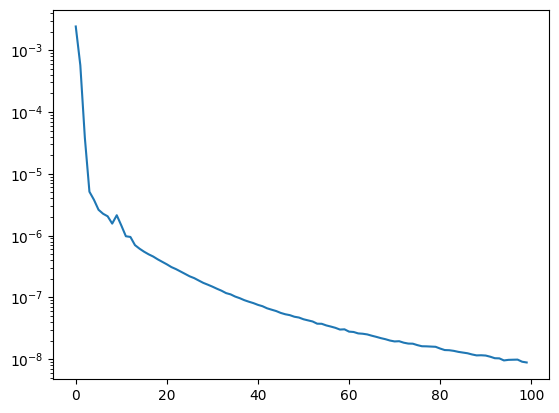

In [ ]:
# Train the model
meta_losses = []
outer_epochs = 100
for epoch in range(outer_epochs):
    # Load the data
    x_batch, y_batch = next(iter(train_loader))
    x_batch = x_batch.to(metalearner.device) # Move to GPU if available
    y_batch = y_batch.to(metalearner.device)
    
    # Take logarithm of y_batch
    y_batch = torch.log(y_batch)

    # Split the data into support and query sets
    x_spt, y_spt, x_qry, y_qry = training.support_query_split(
        x_batch, y_batch, spt_frac=0.6
    )

    # Perform one meta update step across the batch
    meta_loss = metalearner.meta_train(
        x_spt, y_spt, x_qry, y_qry, inner_steps=5
    )
    
    meta_losses.append(meta_loss)
    print(f'Epoch {epoch+1}/{outer_epochs} - Meta Loss: {meta_loss}')

plt.plot(meta_losses)
plt.yscale('log')

# Save meta weights
torch.save(
    metalearner.model.state_dict(),
    '{}batch_{}epoch_metalearner_weights_IA.pt'.format(batch_size, outer_epochs)
)

In [99]:
# test the model on the trunc model

# create torch dataloader from h5 file
ia_file = h5.File(filename, 'r')
samples = ia_file['Trunc'][:]
c_ells = ia_file['Trunc_c_ells'][:]
X = samples
y = np.log(c_ells)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=400, random_state=42)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to('cuda')
X_test = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_train = torch.tensor(y_train, dtype=torch.float32).to('cuda')
y_test = torch.tensor(y_test, dtype=torch.float32).to('cuda')

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

# replace NaN values with 0
X_train = torch.nan_to_num(X_train)
X_test = torch.nan_to_num(X_test)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

Standard model

Epoch 0 Loss: 1.0488935708999634
Epoch 10 Loss: 0.28691864013671875
Epoch 20 Loss: 0.07251975685358047
Epoch 30 Loss: 0.027991751208901405
Epoch 40 Loss: 0.01952710933983326
Epoch 50 Loss: 0.01631675846874714
Epoch 60 Loss: 0.012118963524699211
Epoch 70 Loss: 0.011768082156777382
Epoch 80 Loss: 0.01013271789997816
Epoch 90 Loss: 0.009867124259471893
Epoch 100 Loss: 0.009080985561013222
Epoch 110 Loss: 0.009741868823766708
Epoch 120 Loss: 0.008505239151418209


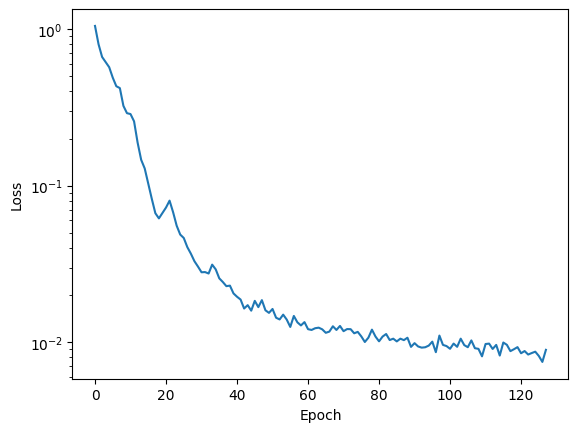

In [100]:
# load the model state
model.load_state_dict(original_model)

n_epochs = 128

train_losses = []
# set training mode
model.train()
for epoch in range(n_epochs):
    X_batch, y_batch = next(iter(train_loader))

    if X_batch.shape[1] < in_size:
        # pad with zeros
        X_batch = torch.cat([X_batch, torch.zeros(X_batch.shape[0], in_size - X_batch.shape[1]).to('cuda')], dim=1)

    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')

    train_losses.append(loss.item())

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

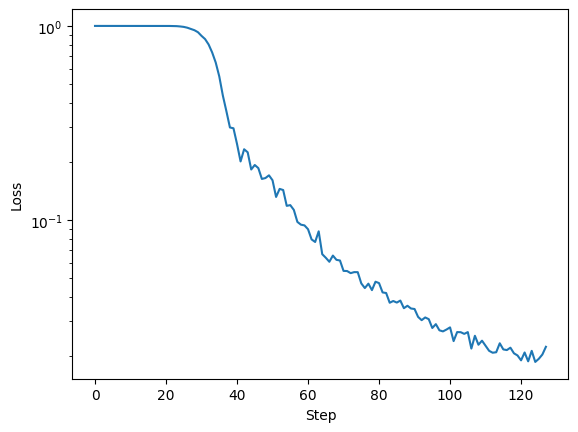

In [101]:
# Perform finetuning
task_weights, losses = metalearner.finetune(X_train, y_train, adapt_steps=128)

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

Total predictions: torch.Size([4600, 750])
Total predictions: torch.Size([4600, 750])


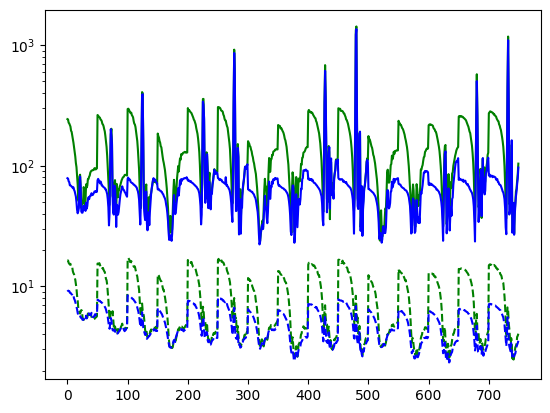

In [102]:
# Construct empty tensor to store predictions
meta_model.eval()
y_pred = torch.tensor([]).to('cuda')
test_losses = []
for X_batch, y_batch in test_loader:
    if X_batch.shape[1] < in_size:
        # pad with zeros
        X_batch = torch.cat([X_batch, torch.zeros(X_batch.shape[0], in_size - X_batch.shape[1]).to('cuda')], dim=1)
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=task_weights)
        test_losses.append(loss_fn(y_pred_batch, y_batch).item())
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)

y_pred = torch.exp(ScalerY.inverse_transform(y_pred)).cpu().detach().numpy()
#y_pred = torch.exp(y_pred).cpu().detach().numpy()
y_true = torch.exp(y_test).cpu().detach().numpy()

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100
worst_ape = np.max(np.abs((y_true - y_pred) / y_true), axis=0) * 100
best_ape = np.min(np.abs((y_true - y_pred) / y_true), axis=0) * 100
plt.plot(mape, c='g', ls='--')
plt.plot(worst_ape, c='g', ls='-')
plt.yscale('log')

#### Standard training ####

# Construct empty tensor to store predictions
model.eval()
y_pred = torch.tensor([]).to('cuda')
test_losses = []
for X_batch, y_batch in test_loader:
    if X_batch.shape[1] < in_size:
        # pad with zeros
        X_batch = torch.cat([X_batch, torch.zeros(X_batch.shape[0], in_size - X_batch.shape[1]).to('cuda')], dim=1)
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = model(X_batch)
        test_losses.append(loss_fn(y_pred_batch, y_batch).item())
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)

y_pred = torch.exp(ScalerY.inverse_transform(y_pred)).cpu().detach().numpy()
#y_pred = torch.exp(y_pred).cpu().detach().numpy()
y_true = torch.exp(y_test).cpu().detach().numpy()

# Compute mean absolute percentage error along the test set
mape = np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100
worst_ape = np.max(np.abs((y_true - y_pred) / y_true), axis=0) * 100
best_ape = np.min(np.abs((y_true - y_pred) / y_true), axis=0) * 100
plt.plot(mape, c='b', ls='--')
plt.plot(worst_ape, c='b', ls='-')
plt.yscale('log')